# Training Wmap for few-shot text classification
This notebook is the second of two to accompany our [Few-Shot Text Classification](https://few-shot-text-classification.fastforwardlabs.com/) report in which we dive into the ins and outs of latent text embeddings for text classifications in several limited-labeled-data regimes. In this notebook we explore how to use latent text embeddings when there are *some* labeled training examples for each of the label names of interest. 

The technique is a continuation of our first notebook in which we demonstrated how to perform text classification with no labeled training data by relying on the inherent meaning of the labels themselves. In this method, label names and the text document you wish to classify are embedded with Sentence-BERT (SBERT). Classification proceeds by assiging the label name whose embedding maximizes the cosine similarity to the text document embedding. 

In our first notebook ([Optimizing Zmap for "on-the-fly" text classification](link)) we improved on this method by optimizing a mapping (Zmap) between SBERT space and word2vec (w2v) space since SBERT is primed to produce better *sentence* embeddings, while w2v produces better *word* embeddings. 

In this notebook, we'll build on this technique and demonstrate how to learn an additional mapping (Wmap) using labeled training data.  

### Notes
* Because this notebook utilizes a Transformer model, GPUs are the prefered hardware if embedding more than a handful of text documents.

### Data to Upload
* reddit_dataset_1300.pt
* reddit_subset_train1000.csv
* reddit_subset_valid1000.csv
* Zmaps

In [ ]:
!nvidia-smi

Wed Dec  9 17:35:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# clone our few-shot repo
!git clone https://github.com/fastforwardlabs/few-shot-text-classification.git

Cloning into 'few-shot-text-classification'...
remote: Enumerating objects: 442, done.
remote: Counting objects: 100% (442/442), done.
remote: Compressing objects: 100% (275/275), done.
remote: Total 442 (delta 281), reused 294 (delta 148), pack-reused 0
Receiving objects: 100% (442/442), 222.90 KiB | 931.00 KiB/s, done.
Resolving deltas: 100% (281/281), done.


After cloning the above repo, `few-shot-text-classification` directory will appear. Move the `fewshot` subdirectory and the `setup.py` script outside of this directory before running the install block below.  

In [ ]:
!pip3 install datasets
!pip3 install transformers
!pip3 install -e .

In [5]:
import os
import pickle
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, tnrange

from fewshot.embeddings import transformer_embeddings as transf

from fewshot.metrics import predict_and_score_Wmap

from fewshot.data.loaders import (
    load_or_cache_data,
    _load_agnews_dataset,
    _create_dataset_from_df,
)
from fewshot.data.utils import select_subsample, expand_labels

from fewshot.utils import (
    fewshot_filename, 
    torch_load,
    torch_save,  
)

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/mbeck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mbeck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
## Load SBERT embedding model
# This will take a bit the first time as the model will be downloaded 
# and cached from the HF Model Repo
model, tokenizer = transf.load_transformer_model_and_tokenizer("deepset/sentence_bert")

## Load Training & Validation Data
  In the following experiments we use two datasets: AG News and the Reddit dataset, both of which can be found on the [HuggingFace Dataset Repository](link) (CAUTION: the Reddit dataset is *very* large and takes a looooong time to download. In our experiments we have already downsampled the dataset to fit in memory. Details on how we did that can be found in [this](link) notebook.)

The AG News train set contains 120,000 examples, of which we'll randomly sample up to 1000 for training (in a later block) and exactly 1000 as a validation set. 


In [7]:
# load agnews train set
df_news_train = _load_agnews_dataset(split="train")

Using custom data configuration default
Reusing dataset ag_news (/Users/mbeck/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a)


In [8]:
# Generate a validation Dataset for hyperparameter tuning
df_news_validation = select_subsample(df_news_train, sample_size=1000, random_state=37)
news_validation = _create_dataset_from_df(df_news_validation, 'text')

Computing sentence representations:   4%|▎         | 9/251 [00:54<24:13,  6.01s/it]


KeyboardInterrupt: 

The Reddit dataset contains nearly 4M examples and is around 20 GiB. In a separate notebook we have already downsampled this dataset to include only 16 of the most popular subreddits and, from those, randomly selected 1000 for training and 1000 for validation. We uploaded these subsets to this notebook. 

**TODO: Host these subsamples somewhere?**

In [10]:
df_reddit_train = pd.read_csv("data/reddit/reddit_subset_train1000.csv")
df_reddit_valid = pd.read_csv("data/reddit/reddit_subset_valid1000.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/reddit/reddit_subset_train1000.csv'

## Load Test Data

These sets will be used for evaluation. Again, the Reddit test set was exctracted from the downsampled dataset described above. In this case we included 1,300 randomly selected examples from the most popular 16 subreddits. 

In [6]:
reddit_test_data = torch_load("data/reddit_dataset_1300.pt")

In [ ]:
news_test_data = load_or_cache_data(datadir="data", dataset_name="agnews")

## Load a relevant Zmap 
In this method, Wmap is learned on SBERT*Zmap representations. This particular Zmap was optimized in our [first notebook](link) and we reuse it here. 

In [13]:
# Load a relevant Zmap for this dataset 
# Note: this one is the most general and will work for all datasets
Zmap_w2v = torch.load("data/Zmaps/Zmap_20k_w2v_words_alpha0.pt")

## Useful methods

In [1]:
from fewshot.models.few_shot import (
    FewShotLinearRegression, 
    BayesianMSELoss,
    prepare_dataloader,
    train,
)   

In [11]:
def hptuning(data_loader, Zmap, validation_data, learning_rates, lambdas, epochs):
  """Hyperparameter tuning for Wmap"""
  score = 0
  for lr in learning_rates:
    for lam in lambdas:
      fewshot_model = FewShotLinearRegression(Zmap.size()[1], Zmap.size()[1], 
                                              loss_fcn=BayesianMSELoss(device='cuda'), 
                                              lr=lr, 
                                              device='cuda')
      loss_history = train(fewshot_model, data_loader, num_epochs=epochs, lam=lam)
      
      Wmap = fewshot_model.linear.weight.detach().cpu()

      new_score = predict_and_score_Wmap(validation_data, Wmap, Zmap)

      if new_score > score:
        score = new_score
        best_lr = lr
        best_lam = lam
        best_model = fewshot_model
        loss = loss_history

  return best_model, best_lr, best_lam, loss

## Training Wmap on the AG News dataset

In this experiment we'll train Wmap using some number of labeled examples for each category. The first order of business is to get a feel for the values of the hyperparametrs: the `learning rate` and the regularization term, `lambda`. 

Wmap is learned through a modification of the traditional loss function for linear least-squares regression with l2 regularization. See the details in our accompanying [report](link).

### Try with 100 labeled examples per category

To begin, we'll start with just 100 annotated examples for each of the four categories in the AG News dataset, for a total of 400 labeled examples. We'll use this to perform our initial hyperparamter search. 

In [ ]:
# select a subsample of the AG news train set containing, at most, 400 examples 
df_news_train_subset = select_subsample(df_news_train, sample_size=100)

# convert that DataFrame to a Dataset
news_train_subset = _create_dataset_from_df(df_news_train_subset, 'text')

# this is required due the particular implementation details of our Dataset class
news_train_subset = expand_labels(news_train_subset)

In [ ]:
# convert the properly formatted training Dataset into a PyTorch DataLoader
data_loader = prepare_dataloader(news_train_subset, Zmap_w2v)

#### Perform hyperparameter search over `learning_rate` and regularization term

I originally performed tuning over learning rates of `[0.001, 0.01, .1, .3, .5]` and after much deliberation determined that `lr=0.1` is a good all-purpose learning rate. 

Smaller learning rates require many more epochs in order to fully minimize the loss. 

In [ ]:
lrs = [0.1]
lambdas = [10, 25, 50, 100, 500, 1000]

# train a new Wmap for every possible combination learning rates and lambdas and
# return the best model and hyperparameters after scoring on the validation set
best_model, best_lr, best_lam, loss = hptuning(data_loader, 
                                               Zmap_w2v, 
                                               news_validation, 
                                               lrs, 
                                               lambdas, 
                                               epochs=3000)

In [ ]:
# time and again, this pair of (learning rate, lambda) cropped up as the best 
best_lr, best_lam

(0.1, 500)

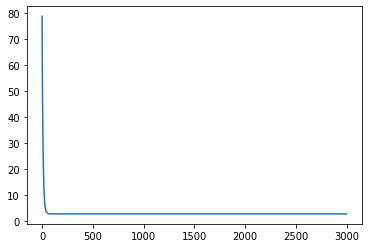

In [ ]:
# visualize the loss as a function of epochs
plt.plot(loss);

Once we have finished the training process, extracting Wmap is as simple as pulling the weights from the linear model as shown below. Wmap is thus a matrix that can be used to transform the SBERT*Zmap representations while taking into account labeled training data. 

In [ ]:
# grab Wmap (weight matrix of the model)
Wmap_100 = best_model.linear.weight.detach().cpu()

# predict on test set
test_score = predict_and_score_Wmap(news_test_data, Wmap_100, Zmap_w2v)

# predict on train set
train_score = predict_and_score_Wmap(news_train_subset, Wmap_100, Zmap_w2v)

print(test_score, train_score)

77.01315789473684 78.0


### Try with 500 labeled examples

Let's repeat the above only this time with 500 examples for each category (2000 training examples total). 

In [34]:
df_news_train500 = select_subsample(df_news_train, sample_size=500)
news_train_subset = _create_dataset_from_df(df_news_train500, 'text')
news_train_subset = expand_labels(news_train_subset)

Computing sentence representations: 100%|██████████| 126/126 [00:26<00:00,  4.75it/s]


In [35]:
data_loader = prepare_dataloader(news_train_subset, Zmap_w2v)

In [ ]:
lrs = [0.1]
lambdas = [10, 50, 100, 500, 1000]

best_model, best_lr, best_lam, loss = hptuning(data_loader, 
                                               Zmap_w2v, 
                                               news_validation, 
                                               lrs, 
                                               lambdas, 
                                               epochs=3000)

0.1 500


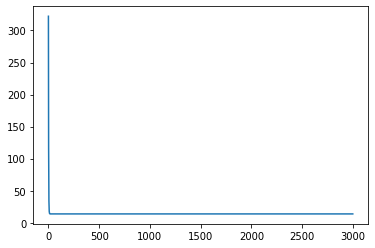

In [ ]:
print(best_lr, best_lam)
plt.plot(loss);

We've now trained two Wmaps -- one trained with only 400 examples and this one trained on 2000 examples. 

In [40]:
# grab the new Wmap
Wmap_500 = best_model.linear.weight.detach().cpu()

# predict on test set
test_score = predict_and_score_Wmap(news_test_data, Wmap_500, Zmap_w2v)

# predict on train set
train_score = predict_and_score_Wmap(news_train_subset, Wmap_500, Zmap_w2v)

print(test_score, train_score)

77.44736842105263 77.75


In [42]:
# Save this Wmap for the demo
torch.save(Wmap_500, "Wmap_agnews_lr0.1_lam500_500expercat.pt")

### Learning Curve
We keep getting the same set of hyperparameters regardless of how many labeled training examples we have. This is great and hints that these values are probably good for a range of training sample sizes. We'll use them in the following experiment where we'll now look at train and test accuracy as a function of how many training examples we have. 

In addition to choosing various `sample_sizes`, we also consider diferent `random_states` in order to account for randomness in the data. That is, we train on five different randomly selected subsamples of 5 training examples each (per category -- 20 total training examples), then we repeat this procedure for each of the `sample_sizes`. 

We'll use the results of this experiment in a figure we construct at the end of the notebook. 

NOTE: running this cell will take 30-60 minutes even with a GPU.

In [ ]:
learning_rate = 0.1
lam = 500 
n_epochs = 500

random_states = [42, 36, 90, 87, 12]
news_results = {}
for random_state in random_states:

  news_test_scores = []
  news_train_scores = []

  sample_sizes = [5, 10, 20, 30, 50, 75, 100, 200, 500]

  for sample_size in sample_sizes:
    df = select_subsample(df_news_train, sample_size=sample_size, 
                          random_state=random_state)
    news_train_subset = _create_dataset_from_df(df, 'text')
    news_train_subset = expand_labels(news_train_subset)

    data_loader = prepare_dataloader(news_train_subset, Zmap_w2v)

    fewshot_model = FewShotLinearRegression(Zmap_w2v.size()[1], Zmap_w2v.size()[1],
                                            loss_fcn=BayesianMSELoss(device='cuda'), 
                                            lr=learning_rate, 
                                            device='cuda')

    loss_history = train(fewshot_model, data_loader, num_epochs=n_epochs, lam=lam)

    Wmap = fewshot_model.linear.weight.detach().cpu()

    # predict on test set
    test_score = predict_and_score_Wmap(news_test_data, Wmap, Zmap_w2v)
    news_test_scores.append(test_score)

    # predict on train set
    train_score = predict_and_score_Wmap(news_train_subset, Wmap, Zmap_w2v)
    news_train_scores.append(train_score)

    news_results[str(random_state)] = [news_test_scores, news_train_scores]

Computing sentence representations: 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Computing sentence representations: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


Computing sentence representations: 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


Computing sentence representations: 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


Computing sentence representations: 100%|██████████| 13/13 [00:02<00:00,  4.81it/s]


Computing sentence representations: 100%|██████████| 19/19 [00:04<00:00,  4.71it/s]


Computing sentence representations: 100%|██████████| 26/26 [00:05<00:00,  4.83it/s]


Computing sentence representations: 100%|██████████| 51/51 [00:10<00:00,  4.77it/s]


Computing sentence representations: 100%|██████████| 126/126 [00:26<00:00,  4.72it/s]


Computing sentence representations: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Computing sentence representations: 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


Computing sentence representations: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


Computing sentence representations: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]


Computing sentence representations: 100%|██████████| 13/13 [00:02<00:00,  4.81it/s]


Computing sentence representations: 100%|██████████| 19/19 [00:04<00:00,  4.71it/s]


Computing sentence representations: 100%|██████████| 26/26 [00:05<00:00,  4.85it/s]


Computing sentence representations: 100%|██████████| 51/51 [00:10<00:00,  4.77it/s]


Computing sentence representations: 100%|██████████| 126/126 [00:26<00:00,  4.73it/s]


Computing sentence representations: 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


Computing sentence representations: 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


Computing sentence representations: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


Computing sentence representations: 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


Computing sentence representations: 100%|██████████| 13/13 [00:02<00:00,  4.80it/s]


Computing sentence representations: 100%|██████████| 19/19 [00:04<00:00,  4.70it/s]


Computing sentence representations: 100%|██████████| 26/26 [00:05<00:00,  4.84it/s]


Computing sentence representations: 100%|██████████| 51/51 [00:10<00:00,  4.76it/s]


Computing sentence representations: 100%|██████████| 126/126 [00:26<00:00,  4.73it/s]


Computing sentence representations: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Computing sentence representations: 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


Computing sentence representations: 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


Computing sentence representations: 100%|██████████| 8/8 [00:01<00:00,  4.86it/s]


Computing sentence representations: 100%|██████████| 13/13 [00:02<00:00,  4.80it/s]


Computing sentence representations: 100%|██████████| 19/19 [00:04<00:00,  4.69it/s]


Computing sentence representations: 100%|██████████| 26/26 [00:05<00:00,  4.83it/s]


Computing sentence representations: 100%|██████████| 51/51 [00:10<00:00,  4.77it/s]


Computing sentence representations: 100%|██████████| 126/126 [00:26<00:00,  4.71it/s]


Computing sentence representations: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


Computing sentence representations: 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


Computing sentence representations: 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


Computing sentence representations: 100%|██████████| 8/8 [00:01<00:00,  4.82it/s]


Computing sentence representations: 100%|██████████| 13/13 [00:02<00:00,  4.80it/s]


Computing sentence representations: 100%|██████████| 19/19 [00:04<00:00,  4.70it/s]


Computing sentence representations: 100%|██████████| 26/26 [00:05<00:00,  4.83it/s]


Computing sentence representations: 100%|██████████| 51/51 [00:10<00:00,  4.76it/s]


Computing sentence representations: 100%|██████████| 126/126 [00:26<00:00,  4.71it/s]


## Training Wmap on the Reddit dataset
We perform the same basic experiments for the Reddit dataset. 

In [ ]:
# select a subset of the reddit training set
df_reddit_train_subset = select_subsample(df_reddit_train, sample_size=100)

# convert that to a properly formated Dataset object
reddit_train_subset = _create_dataset_from_df(df_reddit_train_subset, 'summary')
reddit_train_subset = expand_labels(reddit_train_subset)

Computing sentence representations: 100%|██████████| 64/64 [00:13<00:00,  4.76it/s]


In [ ]:
# convert the reddit validaition set to a Dataset object
reddit_valid = _create_dataset_from_df(df_reddit_valid, "summary")

Computing sentence representations: 100%|██████████| 626/626 [02:14<00:00,  4.64it/s]


In [ ]:
data_loader = prepare_dataloader(reddit_train_subset, Zmap_w2v)

Again, I originally tried several different learning rates but found that once again, 0.1 was the best for most cases. 

In [ ]:
lrs = [0.1]
lambdas = [10, 25, 50, 100, 500, 750, 1000]
epochs = 500

best_model, best_lr, best_lam, loss = hptuning(data_loader, 
                                               Zmap_w2v,
                                               reddit_valid, 
                                               lrs, 
                                               lambdas, 
                                               epochs
                                               )

1000


As with the AG News dataset, the best regularization value was 500. 

0.1 500


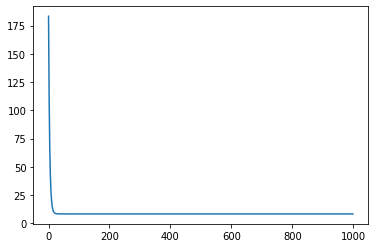

In [ ]:
print(best_lr, best_lam)
plt.plot(loss)

In [ ]:
# grab the Wmap now trained on reddit set
Wmap_100 = best_model.linear.weight.detach().cpu()

# predict on test set
test_score = predict_and_score_Wmap(reddit_test_data, Wmap_100, Zmap_w2v)

# predict on train set
train_score = predict_and_score_Wmap(reddit_train_subset, Wmap_100, Zmap_w2v)

print(test_score, train_score)

44.238461538461536 44.5


### Learning curve

Note that running this cell will take 30-60 minutes even with a GPU due to the number of experiments run. 

In [ ]:
random_states = [42, 36, 90, 87, 12]
results = {}
for random_state in random_states:

  test_scores = []
  train_scores = []

  sample_sizes = [5, 10, 20, 30, 50, 75, 100, 200, 500]

  for sample_size in sample_sizes:
    df = select_subsample(df_reddit_train, 
                          sample_size=sample_size, 
                          random_state=random_state
                          )
    reddit_train_subset = _create_dataset_from_df(df, 'summary')
    reddit_train_subset = expand_labels(reddit_train_subset)

    data_loader = prepare_dataloader(reddit_train_subset, Zmap_w2v)
    #data_loader = prepare_dataloader(reddit_train_subset)

    fewshot_model = FewShotLinearRegression(Zmap_w2v.size()[1], Zmap_w2v.size()[1], 
                                            loss_fcn=BayesianMSELoss(device='cuda'), 
                                            lr=0.1, 
                                            device='cuda')

    loss_history = train(fewshot_model, data_loader, num_epochs=500, lam=500)

    Wmap = fewshot_model.linear.weight.detach().cpu()

    # predict on test set
    test_score = predict_and_score_Wmap(reddit_test_data, Wmap, Zmap_w2v)
    #test_score = predict_and_score_Wmap(reddit_test_data, Wmap)
    test_scores.append(test_score)

    # predict on train set
    train_score = predict_and_score_Wmap(reddit_train_subset, Wmap, Zmap_w2v)
    #train_score = predict_and_score_Wmap(reddit_train_subset, Wmap)
    train_scores.append(train_score)

    results[str(random_state)] = [test_scores, train_scores]

Computing sentence representations: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Computing sentence representations: 100%|██████████| 7/7 [00:01<00:00,  4.77it/s]


Computing sentence representations: 100%|██████████| 14/14 [00:02<00:00,  5.05it/s]


Computing sentence representations: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


Computing sentence representations: 100%|██████████| 32/32 [00:06<00:00,  4.76it/s]


Computing sentence representations: 100%|██████████| 48/48 [00:10<00:00,  4.78it/s]


Computing sentence representations: 100%|██████████| 64/64 [00:13<00:00,  4.81it/s]


Computing sentence representations: 100%|██████████| 126/126 [00:26<00:00,  4.74it/s]


Computing sentence representations: 100%|██████████| 314/314 [01:06<00:00,  4.73it/s]


Computing sentence representations: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Computing sentence representations: 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]


Computing sentence representations: 100%|██████████| 14/14 [00:02<00:00,  5.04it/s]


Computing sentence representations: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


Computing sentence representations: 100%|██████████| 32/32 [00:06<00:00,  4.76it/s]


Computing sentence representations: 100%|██████████| 48/48 [00:10<00:00,  4.79it/s]


Computing sentence representations: 100%|██████████| 64/64 [00:13<00:00,  4.80it/s]


Computing sentence representations: 100%|██████████| 126/126 [00:26<00:00,  4.75it/s]


Computing sentence representations: 100%|██████████| 314/314 [01:06<00:00,  4.73it/s]


Computing sentence representations: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Computing sentence representations: 100%|██████████| 7/7 [00:01<00:00,  4.76it/s]


Computing sentence representations: 100%|██████████| 14/14 [00:02<00:00,  5.05it/s]


Computing sentence representations: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


Computing sentence representations: 100%|██████████| 32/32 [00:06<00:00,  4.75it/s]


Computing sentence representations: 100%|██████████| 48/48 [00:10<00:00,  4.79it/s]


Computing sentence representations: 100%|██████████| 64/64 [00:13<00:00,  4.80it/s]


Computing sentence representations: 100%|██████████| 126/126 [00:26<00:00,  4.75it/s]


Computing sentence representations: 100%|██████████| 314/314 [01:06<00:00,  4.73it/s]


Computing sentence representations: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Computing sentence representations: 100%|██████████| 7/7 [00:01<00:00,  4.77it/s]


Computing sentence representations: 100%|██████████| 14/14 [00:02<00:00,  5.06it/s]


Computing sentence representations: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


Computing sentence representations: 100%|██████████| 32/32 [00:06<00:00,  4.76it/s]


Computing sentence representations: 100%|██████████| 48/48 [00:10<00:00,  4.79it/s]


Computing sentence representations: 100%|██████████| 64/64 [00:13<00:00,  4.81it/s]


Computing sentence representations: 100%|██████████| 126/126 [00:26<00:00,  4.75it/s]


Computing sentence representations: 100%|██████████| 314/314 [01:06<00:00,  4.73it/s]


Computing sentence representations: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Computing sentence representations: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Computing sentence representations: 100%|██████████| 14/14 [00:02<00:00,  5.06it/s]


Computing sentence representations: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


Computing sentence representations: 100%|██████████| 32/32 [00:06<00:00,  4.76it/s]


Computing sentence representations: 100%|██████████| 48/48 [00:10<00:00,  4.78it/s]


Computing sentence representations: 100%|██████████| 64/64 [00:13<00:00,  4.81it/s]


Computing sentence representations: 100%|██████████| 126/126 [00:26<00:00,  4.75it/s]


Computing sentence representations:  59%|█████▊    | 184/314 [00:38<00:27,  4.72it/s]

### Aggregating results

Both of our learning curve experiments were performed over several random samplings of data. Here we combine the results and obtain the average and standard deviation of all the trials for both datasets

In [23]:
all_reddit_test_scores = [np.array(scores[0]) for _, scores in results.items()]
all_reddit_train_scores = [np.array(scores[1]) for _, scores in results.items()]

all_reddit_test_avg = np.mean(all_reddit_test_scores, axis=0)
all_reddit_test_std = np.std(all_reddit_test_scores, axis=0)

all_reddit_train_avg = np.mean(all_reddit_train_scores, axis=0)
all_reddit_train_std = np.std(all_reddit_train_scores, axis=0)


In [24]:
all_reddit_train_avg, all_reddit_train_std

(array([62.8       , 54.        , 49.2       , 46.86666667, 45.8       ,
        45.65333333, 45.46      , 44.93      , 44.388     ]),
 array([7.75628777, 1.54919334, 3.52987252, 2.51749435, 1.81548891,
        1.70040518, 1.59072311, 1.02839681, 0.56577027]))

In [25]:
all_reddit_test_avg, all_reddit_test_std

(array([42.1       , 43.45076923, 43.94923077, 44.07692308, 44.16307692,
        44.15846154, 44.23384615, 44.38615385, 44.36153846]),
 array([0.71900655, 0.28478581, 0.16927272, 0.19695913, 0.12624762,
        0.0973738 , 0.03627639, 0.08247646, 0.08551964]))

In [ ]:
all_news_test_scores = [np.array(scores[0]) for _, scores in news_results.items()]
all_news_train_scores = [np.array(scores[1]) for _, scores in news_results.items()]

all_news_test_avg = np.mean(all_news_test_scores, axis=0)
all_news_test_std = np.std(all_news_test_scores, axis=0)

all_news_train_avg = np.mean(all_news_train_scores, axis=0)
all_news_train_std = np.std(all_news_train_scores, axis=0)

In [ ]:
all_news_train_avg, all_news_train_std

(array([91.        , 88.5       , 84.        , 80.33333333, 80.        ,
        79.73333333, 78.9       , 78.225     , 77.52      ]),
 array([3.74165739, 4.35889894, 3.39116499, 2.5055494 , 1.84390889,
        1.65193489, 1.60156174, 1.51120813, 0.47391982]))

In [ ]:
all_news_test_avg, all_news_test_std

(array([72.92105263, 75.62894737, 75.67894737, 75.54210526, 77.00526316,
        77.00789474, 77.11842105, 77.21842105, 77.37894737]),
 array([1.3720347 , 0.89618304, 0.29675064, 0.33082621, 0.25029069,
        0.26454895, 0.17633543, 0.21062498, 0.11780542]))

## Make a pretty figure

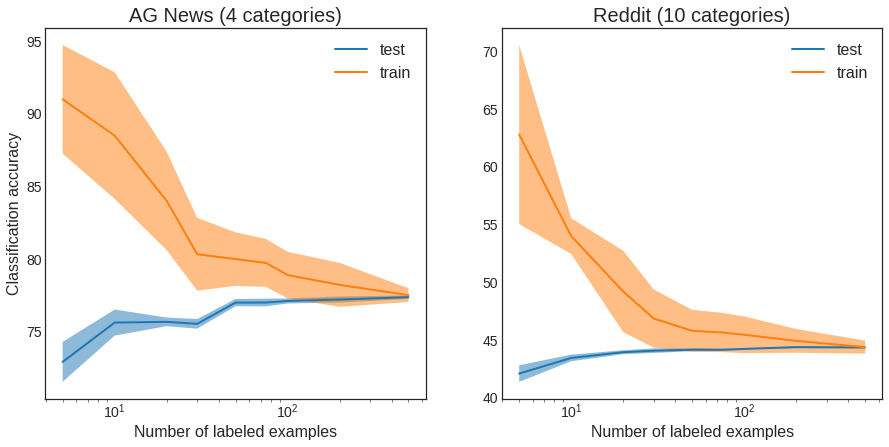

In [33]:
plt.style.use("seaborn-white")

# hardcoded these because sometimes Colab times out (and you lose everything) 
# and re-running those experiments is time consuming
all_news_train_avg = np.array([91., 88.5, 84., 80.33333333, 80., 79.73333333, 78.9, 78.225, 77.52])
all_news_train_std = np.array([3.74165739, 4.35889894, 3.39116499, 2.5055494 , 1.84390889, 1.65193489, 1.60156174, 1.51120813, 0.47391982])
all_news_test_avg = np.array([72.92105263, 75.62894737, 75.67894737, 75.54210526, 77.00526316, 77.00789474, 77.11842105, 77.21842105, 77.37894737])
all_news_test_std = np.array([1.3720347 , 0.89618304, 0.29675064, 0.33082621, 0.25029069, 0.26454895, 0.17633543, 0.21062498, 0.11780542])

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(221)
ax.plot(sample_sizes, all_news_test_avg, lw=2, label="test")
ax.fill_between(sample_sizes, 
                 all_news_test_avg-all_news_test_std, 
                 all_news_test_avg+all_news_test_std, 
                 alpha=0.5)
ax.semilogx(sample_sizes, all_news_train_avg, lw=2, label="train")
ax.fill_between(sample_sizes, 
                 all_news_train_avg-all_news_train_std, 
                 all_news_train_avg+all_news_train_std, 
                 alpha=0.5)
ax.set_title("AG News (4 categories)", fontsize=20)

ax.set_ylabel("Classification accuracy", fontsize=16)
ax.set_xlabel("Number of labeled examples", fontsize=16)
ax.tick_params(axis='both', labelsize=14)
ax.tick_params(which='minor', length=3)
ax.legend(frameon=False, fontsize=16)

ax2 = fig.add_subplot(222)
ax2.plot(sample_sizes, all_reddit_test_avg, lw=2, label="test")
ax2.fill_between(sample_sizes, 
                 all_reddit_test_avg-all_reddit_test_std, 
                 all_reddit_test_avg+all_reddit_test_std, 
                 alpha=0.5)

ax2.semilogx(sample_sizes, all_reddit_train_avg, lw=2, label="train")
ax2.fill_between(sample_sizes, 
                 all_reddit_train_avg-all_reddit_train_std, 
                 all_reddit_train_avg+all_reddit_train_std, 
                 alpha=0.5)
ax2.set_title("Reddit (10 categories)", fontsize=20)
ax2.set_xlabel("Number of labeled examples", fontsize=16)
ax2.tick_params(axis='both', labelsize=14)
ax2.tick_params(which='minor', length=3)
ax2.legend(frameon=False, fontsize=16);
plt.tight_layout()
plt.savefig("learningcurves_agnews_reddit.png", transparent=True, dpi=150)

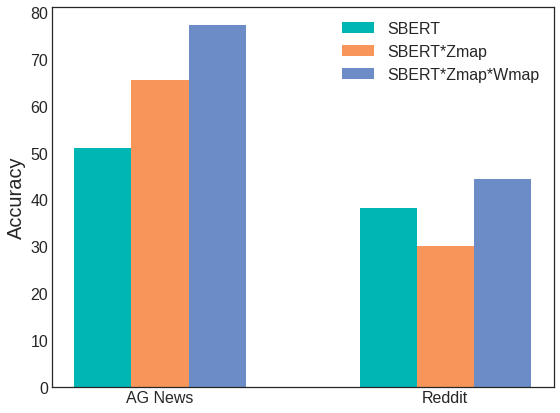

In [18]:
plt.style.use("seaborn-white")
cldr_colors = ['#00b6b5', '#f7955b','#6c8cc7']

# from the Zmap_Experiments Colab notebook
baseline_news_acc = 51.0921052631579
baseline_reddit_acc = 38.36712428402582

Zmap_news_acc = 65.57894736842104
Zmap_reddit_acc = 30.26335727490378

Wmap_news_acc = 77.42105263157895
Wmap_reddit_acc = 44.40769230769231

fig = plt.figure(figsize=(9,7))
width = 0.20
plt.bar(np.array([0, 1])-width, [baseline_news_acc, baseline_reddit_acc], 
        width=width, color=cldr_colors[0],  label='SBERT')
plt.bar(np.array([0, 1]), [Zmap_news_acc, Zmap_reddit_acc], 
        width=width, color=cldr_colors[1], label="SBERT*Zmap")
plt.bar(np.array([0, 1])+width, [Wmap_news_acc, Wmap_reddit_acc], 
        width=width, color=cldr_colors[2], label="SBERT*Zmap*Wmap")

#plt.bar(1.5, zred_reddit_acc, width=width)
plt.xticks([0,1], ['AG News', 'Reddit'], fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Accuracy", fontsize=20);
plt.legend(frameon=False, fontsize=16);

plt.savefig("accuracy_Wmap_agnews_reddit.png", transparent=True, dpi=150)

***If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices.  A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).***